# Hypothesis Testing with Insurance Data

Dataset: US Health Insurance from Kaggle

We have been asked to use our hypothesis testing skills to answer the following questions:

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

For each question, make sure to:

- State your Null Hypothesis and Alternative Hypothesis
- Select the correct test according to the data type and number of samples
- Test the assumptions of your selected test.
- Execute the selected test, or the alternative test (if you do not meet the assumptions)
- Interpret your p-value and reject or fail to reject your null hypothesis 
- Show a supporting visualization that helps display the result



In [1]:
#Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
#load data from kaggle

url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1: Do smokers have higher insurance charges than non-smokers?

Null Hypothesis: There is no difference in the insurance costs between smokers and non smokers.

Alternative hypothesis: There is a significant difference in the insurance costs between smokers and non smokers.

Test: Independent 2 sample t-test

In [3]:
#separate smoker and non smoker groups

smoker = df.loc[df['smoker']=='yes', ['smoker', 'charges']]
smoker.head()

,smoker,charges
0,yes,16884.9240
11,yes,27808.7251
14,yes,39611.7577
19,yes,36837.4670
23,yes,37701.8768


In [5]:
non_smoker = df.loc[df['smoker']=='no', ['smoker', 'charges']]
non_smoker.head()

,smoker,charges
1,no,1725.55230
2,no,4449.46200
3,no,21984.47061
4,no,3866.85520
5,no,3756.62160


In [7]:
#for visualization later

plot_df = pd.concat([smoker, non_smoker])
plot_df

,smoker,charges
0,yes,16884.9240
11,yes,27808.7251
14,yes,39611.7577
19,yes,36837.4670
23,yes,37701.8768
...,...,...
1332,no,11411.6850
1333,no,10600.5483
1334,no,2205.9808
1335,no,1629.8335


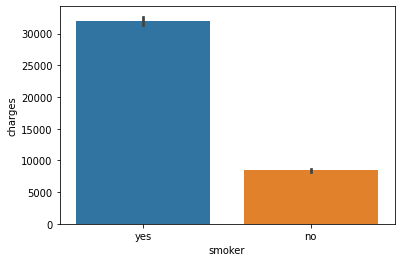

In [9]:
sns.barplot(data=plot_df, x='smoker', y='charges', ci=68);

### Outliers

In [10]:
#smokers

smoker_group = smoker['charges']
smoker_outliers = np.abs(stats.zscore(smoker_group)) > 3
smoker_outliers.sum()

0

In [11]:
#non-smoker

non_smoker_group = non_smoker['charges']
non_smoker_outliers = np.abs(stats.zscore(non_smoker_group)) > 3
non_smoker_outliers.sum()

24

In [13]:
#remove outliers for non_smoker group

non_smoker_group = non_smoker_group.loc[~non_smoker_outliers]

### Normality

In [14]:
#test for normality

result = stats.normaltest(smoker_group)
result.pvalue

5.564930630036463e-14

In [16]:
result = stats.normaltest(non_smoker_group)
result.pvalue

2.6945416315543976e-36

In [18]:
#determine group size

display(len(smoker), len(non_smoker))

274

1064

Can disregard the pvalue because the groups are large. 

### Equal Variance

In [21]:
#test for equal variance

result = stats.levene(smoker_group, non_smoker_group)
print(result)
if result.pvalue < 0.05:
  print('The groups do NOT have equal variance.')
else: 
  print ('The groups DO have equal variance, will run welchs test.')

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)
The groups do NOT have equal variance.


In [22]:
#final hypothesis

result = stats.ttest_ind(smoker_group, non_smoker_group, equal_var=False)
print(result)
result.pvalue < 0.05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

The p value was less than 0.05 for the Welch's t test, meaning we reject the null hypothesis and support the alternative hypothesis. There is a significant difference in insurance costs between smokers and non-smokers.

## Q2: Are men more likely to smoke than women?

Null Hypothesis: There is no difference between men and women who smoke

Alternative hypothesis: There is a significant difference between men and women who smoke

Test: categorical, chi-test, and 4 sample groups

In [25]:
#separate smoker, male and female groups

male = df.loc[df['sex']=='male', ['sex', 'smoker']]
male.head()

,sex,smoker
1,male,no
2,male,no
3,male,no
4,male,no
8,male,no


In [24]:
female = df.loc[df['sex']=='female', ['sex', 'smoker']]
female.head()

,sex,smoker
0,female,yes
5,female,no
6,female,no
7,female,no
9,female,no


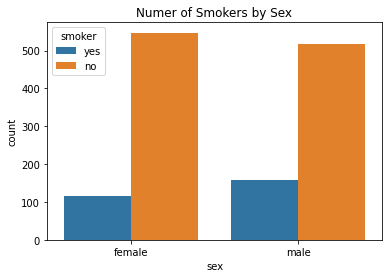

In [29]:
#visual

ax = sns.countplot(data = df, x='sex', hue='smoker')
ax.set_title('Numer of Smokers by Sex');

In [30]:
#calculate the contigency table with pd.cross-tab

table = pd.crosstab(df['sex'],df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [31]:
#run the test and save the output

result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [32]:
# calculate p-value

print(p)
p<0.05

0.006548143503580696


True

The p-value is less than 0.05. We reject the null and support the alternative hypothesis. There is a difference between men and women who smoke, men likely to smoke more.

## Q3. Do different regions have different charges, on average?

Null Hypothesis: There is no difference in charges between regions

Alternative hypothesis: There is a significant difference in charges between regions

Test: multiple samples/groups and numerical

In [33]:
#separate into appropriate groups

groups = {}
for region in df['region'].unique():
  temp_df = df.loc[df['region']==region, 'charges']
  groups[region] = temp_df
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

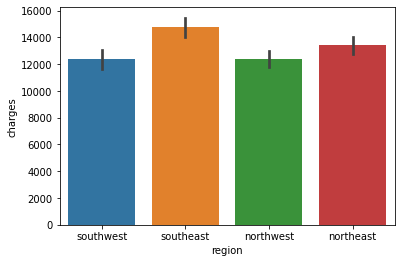

In [35]:
#graph and visualize the results

sns.barplot(data = df, x='region', y='charges', ci=68);

### Outliers

In [36]:
for region, data in groups.items():
  outliers = np.abs(stats.zscore(data)) > 3
  print(f'{outliers.sum()} outliers were removed from the {region} group')
  groups[region] = data.loc[~outliers]

8 outliers were removed from the southwest group
2 outliers were removed from the southeast group
7 outliers were removed from the northwest group
4 outliers were removed from the northeast group


### Normality

In [38]:
norm_results = {}
for i, data in groups.items():
  stat, p = stats.normaltest(data)
  norm_results[i] = {'n':len(data),
                     'p':p}

In [39]:
#display dataframe created from the norm results

pd.DataFrame(norm_results).T

,n,p
southwest,317.0,7.728611e-22
southeast,362.0,1.936990e-13
northwest,318.0,2.940543e-19
northeast,320.0,3.557877e-17


In [40]:
#display dataframe created from norm_results

norm_df = pd.DataFrame(norm_results).T
norm_df['sig?'] = norm_df['p'] < 0.05
norm_df

,n,p,sig?
southwest,317.0,7.728611e-22,True
southeast,362.0,1.936990e-13,True
northwest,318.0,2.940543e-19,True
northeast,320.0,3.557877e-17,True


Large enough group, disregard normality

### Equal Variance

In [41]:
statistic, pvalue = stats.levene(*groups.values())
print(statistic, pvalue)
if pvalue < 0.05:
  print('The groups do NOT have equal variance')
else: 
  print ('The groups DO have equal variance')

9.518349004554441 3.2035503711783993e-06
The groups do NOT have equal variance


Kruskal test

In [42]:
#final hypothesis

statistic, pvalue = stats.kruskal(*groups.values())
print(statistic, pvalue)

6.914045702545643 0.07468847911322242


The p-value is greater than 0.05. We failed to reject the null and support the null hypothesis. There is no significant difference in charges between regions.